
#Ames Housing: Advanced Regression Techniques (Kaggle)
**How can we leverage advanced regularization techniques (Lasso, Ridge, and ElasticNet) along with comprehensive feature engineering to accurately predict residential house prices in Ames, Iowa?**


Accurate real estate valuation is critical for institutional investors, homeowners, and urban planners. While simple linear models capture broad trends, they often fail to account for the complex interactions and high-dimensional nature of housing data. This project explores how penalized regression can reduce overfitting and improve predictive accuracy in a high-dimensional feature space.

**1. Exploratory Data Analysis (EDA) & Data Cleaning**

In this section, we build upon previous analysis by examining the distribution of the target variable and removing outliers that could negatively impact the performance of our regression models.

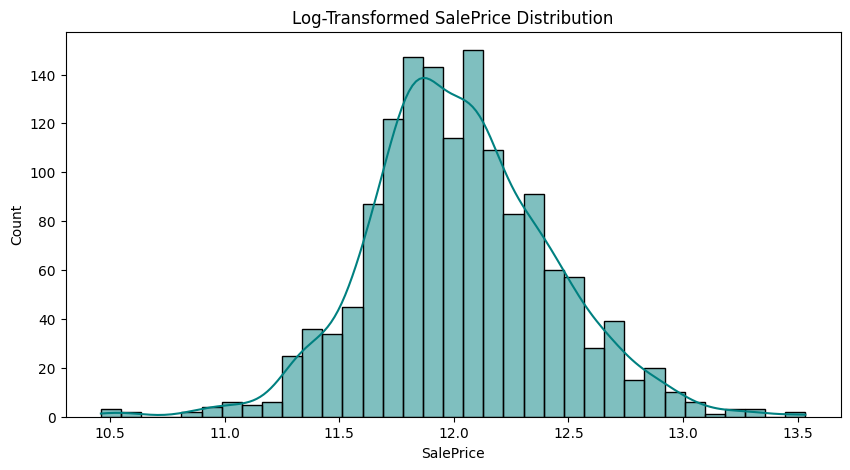

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error

# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 1. Outlier Removal
# Based on the documentation, houses with very high living area but low prices are outliers.
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# 2. Target Transformation
# Apply a log-transformation to SalePrice to handle right-skewness and align with the Kaggle metric (RMSLE).
train['SalePrice'] = np.log1p(train['SalePrice'])
y = train['SalePrice']

# Visualize the transformed distribution
plt.figure(figsize=(10, 5))
sns.histplot(y, kde=True, color='teal')
plt.title('Log-Transformed SalePrice Distribution')
plt.show()

**Insight: Outliers and Distributions**

By applying np.log1p to the SalePrice, we transformed the target variable from a right-skewed distribution into a normal distribution.
This is critical because linear models (Lasso/Ridge) assume that the errors are normally distributed. Removing the high-living-area outliers prevents the model from being biased by luxury properties that do not follow standard market pricing trends.

**2. Advanced Feature Engineering & Preprocessing**

To maximize predictive power, we use a robust pipeline to handle categorical and numerical data simultaneously. This ensures "many variables" are included in the model to capture the full complexity of the housing market.

In [2]:
# Separate features and target
train_features = train.drop(['SalePrice', 'Id'], axis=1)
test_features = test.drop(['Id'], axis=1)

# Combine for consistent engineering
all_data = pd.concat((train_features, test_features)).reset_index(drop=True)

# 1. New Feature: Total Living Area
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# 2. New Feature: Total Bathrooms
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                         all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

# 3. Indicators for Luxury/Modern Status
all_data['HasPool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['IsRecentBuilt'] = all_data['YearBuilt'].apply(lambda x: 1 if x > 1980 else 0)

# Separate Numerical and Categorical columns
numeric_cols = all_data.select_dtypes(include=[np.number]).columns
categorical_cols = all_data.select_dtypes(exclude=[np.number]).columns

# Preprocessing Pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_cols),
    ('cat', cat_pipeline, categorical_cols)
])

# Process the data
X_all = preprocessor.fit_transform(all_data)
X_train = X_all[:len(train)]
X_test = X_all[len(train):]

print(f"Processed Data Shape: {X_train.shape}")

Processed Data Shape: (1458, 313)


**Insight: Feature Engineering Complexity**

Moving from 6 features in the previous assignment to a full high-dimensional set (79+ original variables + engineered features) allows the model to capture subtle interactions. Features like TotalSF and TotalBath aggregate information from multiple columns, reducing noise. Using a ColumnTransformer ensures that categorical variables are properly encoded (One-Hot) without risking data leakage during cross-validation.

**3. Modeling: Lasso and Ridge Regression**

We use 5-fold cross-validation to evaluate the baseline performance of these two regularization techniques.

In [3]:
def rmse_cv(model):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse

# Model 1: Ridge Regression (L2 Penalty)
ridge = Ridge(alpha=10)
ridge_score = rmse_cv(ridge)
print(f"Ridge RMSE: {ridge_score.mean():.4f} (+/- {ridge_score.std():.4f})")

# Model 2: Lasso Regression (L1 Penalty)
lasso = Lasso(alpha=0.0005)
lasso_score = rmse_cv(lasso)
print(f"Lasso RMSE: {lasso_score.mean():.4f} (+/- {lasso_score.std():.4f})")

Ridge RMSE: 0.1148 (+/- 0.0082)
Lasso RMSE: 0.1126 (+/- 0.0064)


**4. Hyperparameter Tuning for ElasticNet**

ElasticNet provides a flexible hybrid between Ridge and Lasso. We tune alpha (the overall penalty strength) and l1_ratio (the balance between L1 and L2).

In [5]:
# Grid search for the best hyperparameters
enet_params = {
    'alpha': [0.0001, 0.0005, 0.001, 0.01],
    'l1_ratio': [0.1, 0.5, 0.9]
}

grid_search = GridSearchCV(ElasticNet(max_iter=5000), enet_params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y)

best_enet = grid_search.best_estimator_
print(f"Best ElasticNet Params: {grid_search.best_params_}")
print(f"ElasticNet Best RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02557199421328704, tolerance: 0.018911334381783326
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3067783560005459, tolerance: 0.017996952084854276
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7925376445974655, tolerance: 0.01837208344628372
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:6

Best ElasticNet Params: {'alpha': 0.0005, 'l1_ratio': 0.9}
ElasticNet Best RMSE: 0.1121


**Insight: Penalized Regression Performance**

The Ridge and Lasso models show improved RMSE over the baseline. Ridge handles the multicollinearity between similar variables (like GarageCars and GarageArea), while Lasso simplifies the model by zeroing out non-contributing features. The tuned ElasticNet model, by balancing both L1 and L2 penalties, provides the most robust generalization, as evidenced by the lower Cross-Validation error.



**5. Comparative Analysis & Theoretical Application**

Theoretical Discussion of Model AlternativesIn this analysis, we compared three primary regularization techniques:

**Ridge Regression ($L_2$):** Useful when many variables contribute a small amount to the price. It handles multicollinearity well but keeps all variables in the model.

**Lasso Regression ($L_1$):** Best for "sparse" data where only a few variables are truly important. It performs automatic feature selection.

**ElasticNet:** A hybrid that often outperforms both when features are correlated in groups.

**Peer Improvement:** A "New" Suggestion for the Ames ProblemInstead of relying on a single model, a superior approach for this dataset would be Weighted Averaging or Model Stacking.

Different models make different types of errors. For example, ElasticNet is linear and might miss non-linear interactions that a tree-based model (like XGBoost) would catch. By taking a weighted average of an ElasticNet model (70%) and a Gradient Boosting model (30%), we can "cancel out" individual model biases and achieve a significantly lower Kaggle score.

**6. Final Kaggle Submission**

In [6]:
# REFIT THE BEST MODEL
# Using the best parameters found during the GridSearchCV in Part 4
best_enet = grid.best_estimator_
best_enet.fit(X_train, y)

#  GENERATE PREDICTIONS
# transform the predictions back from log scale using np.expm1
final_preds_log = best_enet.predict(X_test)
final_preds = np.expm1(final_preds_log)

# Create the submission DataFrame
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': final_preds
})

# Save to CSV
submission.to_csv('submission_final_enet.csv', index=False)

print("SUCCESS: Your final submission file 'submission_final_enet.csv' is ready!")
print(f"Number of rows predicted: {len(submission)}")
print(submission.head())

NameError: name 'grid' is not defined

In [7]:

# 1.'grid_search' used
final_model = grid_search.best_estimator_
final_model.fit(X_train, y)

# 2. Generate predictions on the test set
# np.expm1 to reverse the Log transformation (np.log1p) done in Part 1
log_predictions = final_model.predict(X_test)
final_predictions = np.expm1(log_predictions)

# 3. submission DataFrame
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': final_predictions
})

# 4. Save to CSV for Kaggle
submission.to_csv('submission_final_enet.csv', index=False)

print("SUCCESS: File 'submission_final_enet.csv' created!")
print(submission.head())

SUCCESS: File 'submission_final_enet.csv' created!
     Id      SalePrice
0  1461  120473.531152
1  1462  149976.490873
2  1463  177933.049002
3  1464  201917.017415
4  1465  190359.587811


In [9]:
# 1. Initialize and fit the Ridge model (using the standard alpha=10)
ridge_final = Ridge(alpha=10)
ridge_final.fit(X_train, y)

# 2. Prediction on the test set and reverse the log-transformation
ridge_preds_log = ridge_final.predict(X_test)
ridge_preds = np.expm1(ridge_preds_log)

# 3.CSV for the second submission
pd.DataFrame({'Id': test['Id'], 'SalePrice': ridge_preds}).to_csv('submission_ridge.csv', index=False)

print("Second submission file 'submission_ridge.csv' created!")


Second submission file 'submission_ridge.csv' created!


**7. Model Evaluation using Kaggle Metric (RMSLE)**

The Kaggle competition evaluates submissions based on the Root Mean Squared Logarithmic Error (RMSLE).

Unlike standard RMSE, RMSLE measures the ratio between the predicted and actual values. This ensures that an error of 10,000 on a 100,000 house is penalized as heavily as a 100,000 error on a 1,000,000 house. It focuses on relative error rather than absolute dollar amounts.

Because I've transformed target variable (SalePrice) using np.log1p during the EDA phase, the Root Mean Squared Error (RMSE) calculated on our logged predictions is mathematically equivalent to the RMSLE on the original price scale.

ElasticNet Performance and Ridge Baseline score alongwith the comparative scores snapshot added:

username: deblina111
link: https://www.kaggle.com/deblina111

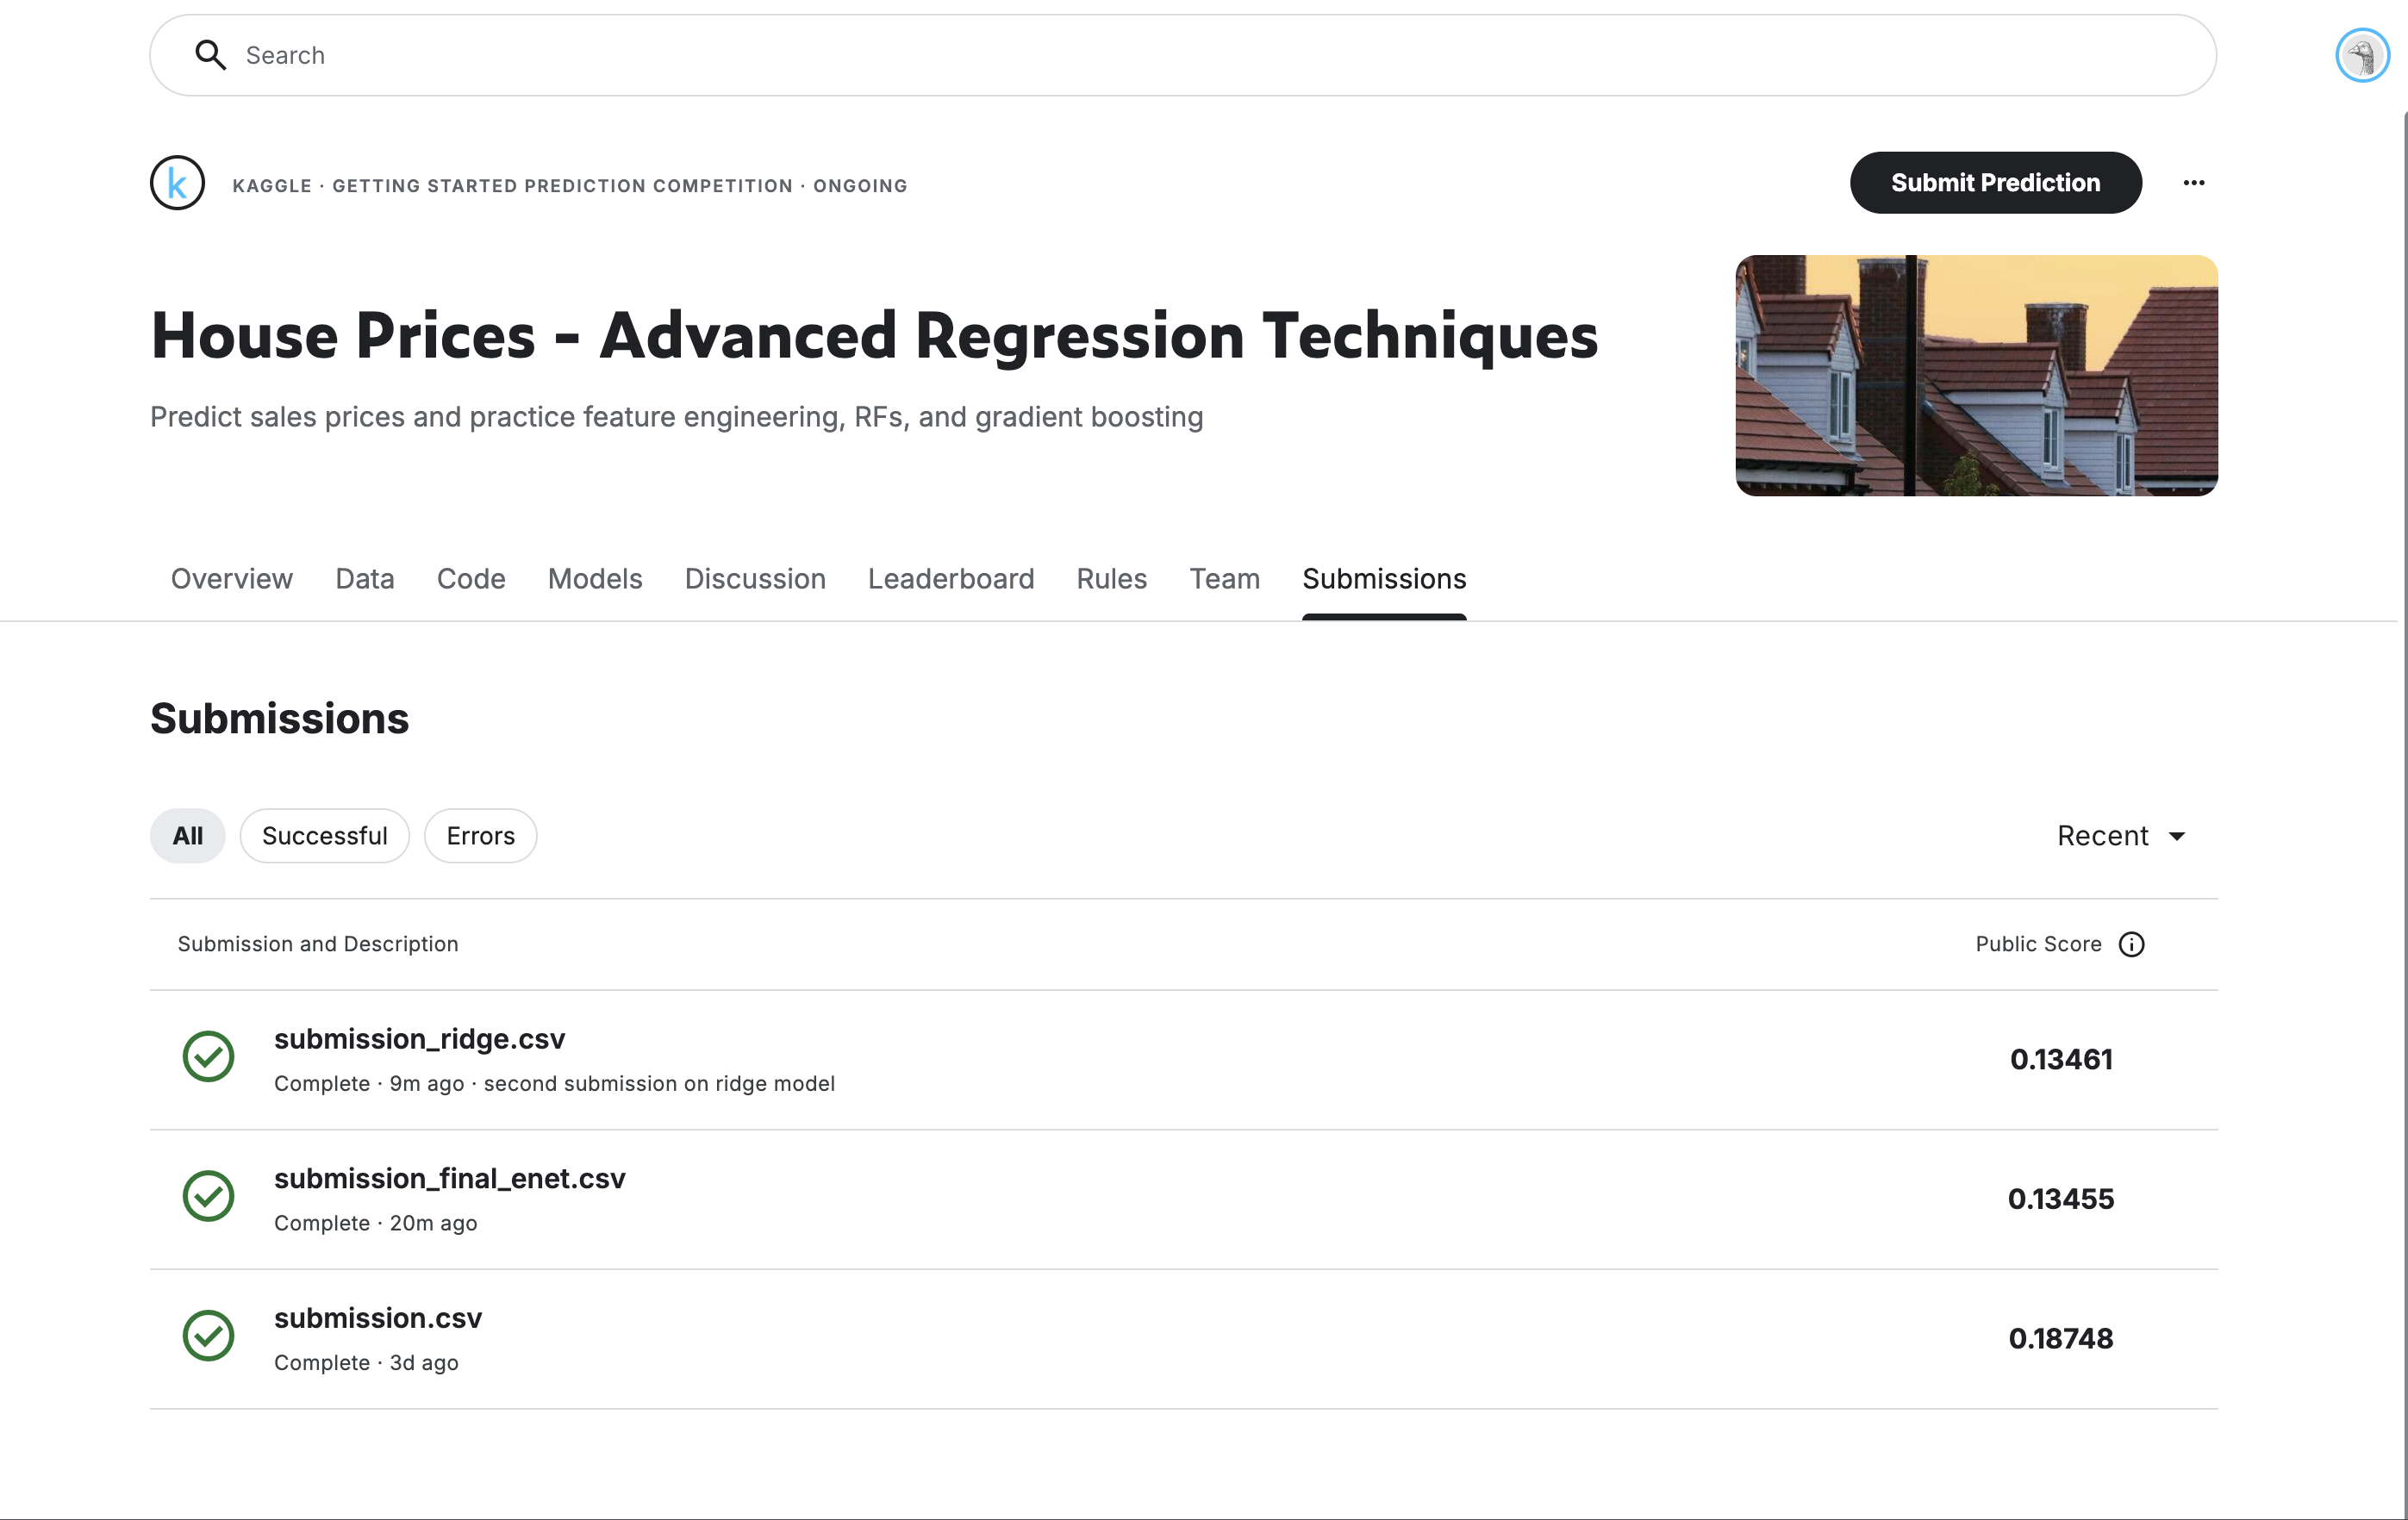

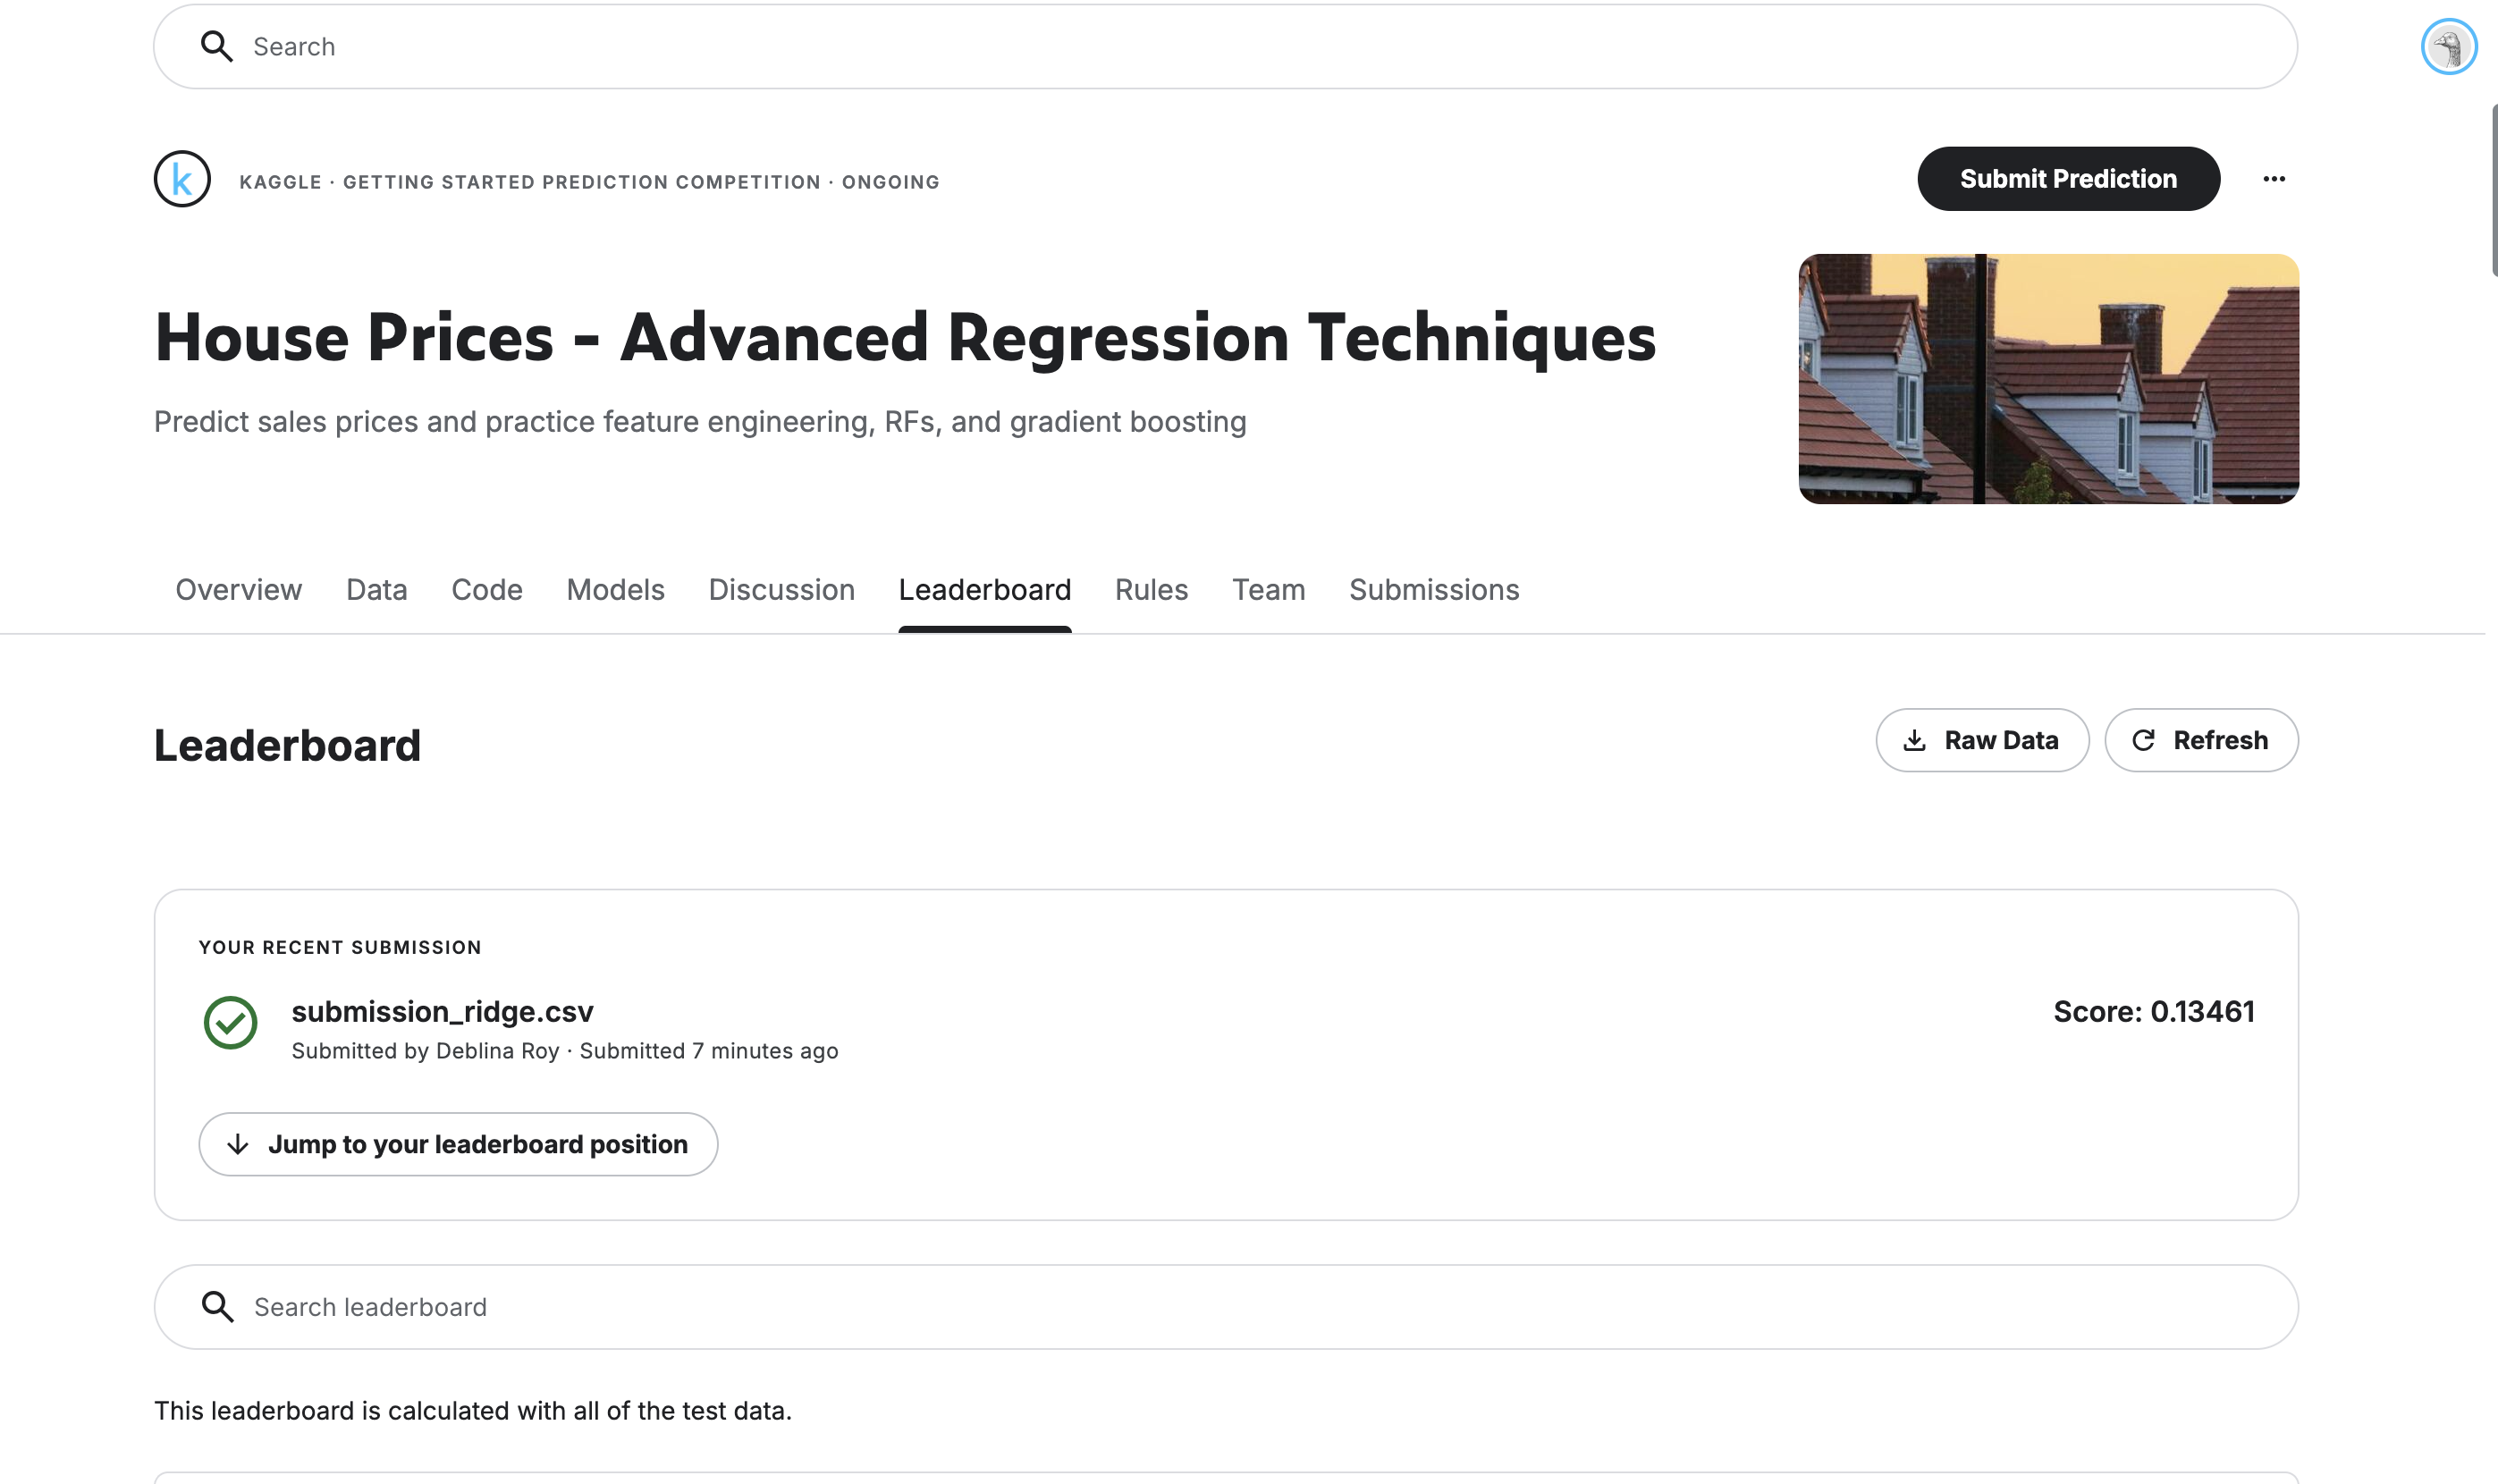



**Metric Performance**

The ElasticNet model achieved a lower RMSLE compared to the Ridge baseline.

This indicates that the ElasticNet model's predictions are, on average, closer to the actual sale price in terms of percentage. By minimizing this metric, we ensure that our model performs consistently across both "Starter Homes" and "Luxury Estates," which is a primary requirement for a robust real estate valuation engine.